## False and true positive rates for outliers in certain regions
Motvated by other papers

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

from GWMockCat.vt_utils import interpolate_optimal_snr_grid, draw_thetas
from GWMockCat.cosmo_utils import interp_cosmology


from gw_lensing_outliers import sampling, dists
from gw_lensing_outliers import transforms as trans
from gw_lensing_outliers import analysis_functions as af
from gw_lensing_outliers.dists import ZMAX

matplotlib.rcParams["contour.negative_linestyle"]="solid"
matplotlib.rcParams["text.usetex"]=True
matplotlib.rcParams['font.family']='serif'
matplotlib.rcParams['font.size']=12
plt.rcParams.update( {'axes.labelsize':12, 'axes.titlesize':12, 'legend.fontsize':10, 'text.usetex':True} )

color_og_light, color_og_dark = "#8da0cb", "#7570b3"
color_lensing_light, color_lensing_dark =  "#66c2a5", "#1b9e77"
color_alt_light, color_alt_dark = "#fc8d62", "#d95f02"

MU_MAX = 2500
GWMOCKCAT_COSMO_DICT = interp_cosmology(zmax=30)
O4_MEASUREMENT_UNCERTAINTY = dict(threshold_snr=8.,snr=1.,mc=8e-2,Theta=8e-2,eta=1e-2)
O4_total_obs_time = np.array([34,42,36])/52 # convert weeks to years, each enrty is a chunk of O4
O4_duty_cycle = np.array([1-.166,.368+.311+.208/2,.346+.391+.173/2]) 
O4_OBS_TIME = np.sum(O4_total_obs_time * O4_duty_cycle)

np_rng = np.random.default_rng(62)

In [3]:
# define population model
## redshift: shouts and murmurs
baseline = dict(alpha=2.7,beta=2.9,zp=1.9) # note this is peaked at lower redshifts than ours!

## mass: flat in m1,m2 between 1 and 2.5
min_mass = 1
max_mass = 2.5

# magnification
mu_interp, ln_mu_space, z_space, t_const_space = af.make_Dai_interpolant('../data/Dai_logmag_pdf_t0const_neg0p36_100_grid.h5',make_new=False, return_grids=True)

In [5]:
# make injections without lensing
N_INJ = int(5e8)

true_redshifts = sampling.inverse_transform_sample(dists.shouts_murmurs,[1e-3,ZMAX],rng=np_rng,N=N_INJ,**baseline) 
true_distances = trans.dL_approx(true_redshifts)
thetas = draw_thetas(N_INJ,np_rng)
pdraw = dists.shouts_murmurs(true_redshifts,**baseline)

true_src_masses = np_rng.uniform(low=min_mass,high=max_mass,size=N_INJ)
q = np.ones(N_INJ)
det_masses = true_src_masses * (1 + true_redshifts)
pdraw *= np.ones(N_INJ)/(max_mass - min_mass)

injections_unlensed = dict(true_src_mass=true_src_masses,
                      det_mass=det_masses,
                      mass_ratio=q,
                      true_redshift=true_redshifts,
                      true_distance=true_distances,
                      sky_angle=thetas,
                      inferred_distance=true_distances,
                      inferred_redshift=true_redshifts,
                      inferred_src_mass=true_src_masses,
                      mass_z_pdraw=pdraw,
                      num_injections=N_INJ,
                      magnification=np.ones_like(true_src_masses),
                      lnmu_pdraw=np.ones_like(true_src_masses),
)

In [6]:
# make those same injections with lensing
log_min_mag = ln_mu_space[0]
log_max_mag = ln_mu_space[-1]
logmags = np_rng.uniform(log_min_mag,log_max_mag,size=N_INJ)
logmu_pdraw = np.ones(N_INJ)/(log_max_mag - log_min_mag)
mags = np.exp(logmags)

inferred_distances, inferred_redshifts, inferred_src_masses = trans.inferred_quantities_from_lensing(mags, det_masses, true_distances)

injections_lensed = injections_unlensed.copy()
injections_lensed['magnification'] = mags
injections_lensed['inferred_distance'] = inferred_distances
injections_lensed['inferred_redshift'] = inferred_redshifts
injections_lensed['inferred_src_mass'] = inferred_src_masses
injections_lensed['lnmu_pdraw'] = logmu_pdraw

In [7]:
# find both sets of injections
detector = "aligo_O4low"
osnr, dist_unit = interpolate_optimal_snr_grid(
            f"/Users/amandafarah/Library/Mobile Documents/com~apple~CloudDocs/projects/mock-PE/sensitivity/optimal_snr_{detector}.h5")

obs_found_evs_unlensed, identified_evs_unlensed = af.find_injections(np_rng,injections_unlensed,m1max_thresh,0,osnr,dist_unit,O4_MEASUREMENT_UNCERTAINTY,cosmo_dict=GWMOCKCAT_COSMO_DICT)
obs_found_evs_lensed, identified_evs_lensed = af.find_injections(np_rng,injections_lensed,m1max_thresh,0,osnr,dist_unit,O4_MEASUREMENT_UNCERTAINTY,cosmo_dict=GWMOCKCAT_COSMO_DICT)

5202 found injections
1996 injections found and identified as outliers
29611328 found injections
27802056 injections found and identified as outliers


In [8]:
obs_found_evs_lensed['num_found'] / N_INJ , identified_evs_lensed['identified_bool'].sum() / N_INJ

(0.059222656, 0.055604112)

In [9]:
# calculate Nexp in the gap for both sets of injections
z_dummy = np.linspace(0.001,ZMAX,num=100)
total_rate = 15 * np.trapz(x=z_dummy,y=dists.shouts_murmurs(
    z_dummy,**baseline)
)

Nexp_outlier_unlensed = identified_evs_unlensed['identified_bool'].sum() / N_INJ   * total_rate * O4_OBS_TIME 

t_const = 0.0
found_weights = mu_interp((np.log(obs_found_evs_lensed['magnification']),obs_found_evs_lensed['true_redshift'],t_const)) / obs_found_evs_lensed['lnmu_pdraw']
identified_weights = found_weights[identified_evs_lensed['identified_bool']]  
Nexp_outlier_lensed = identified_weights.sum() / N_INJ   * total_rate * O4_OBS_TIME 


In [10]:
Nexp_outlier_unlensed,Nexp_outlier_lensed

(0.41975057589526904, 0.4106906938432659)

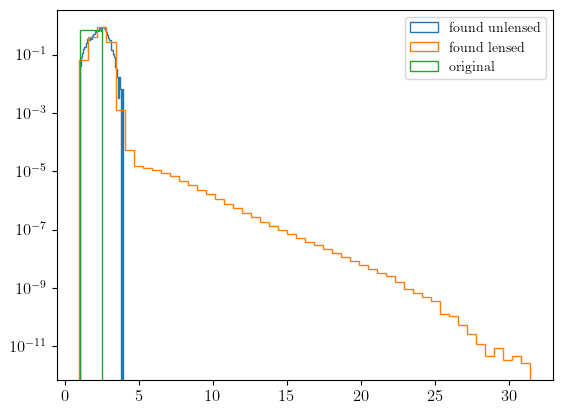

In [11]:
hist_kwargs = dict(bins=50,density=True,histtype='step')

plt.hist(obs_found_evs_unlensed['inferred_src_mass'],**hist_kwargs,label='found unlensed')
plt.hist(obs_found_evs_lensed['inferred_src_mass'],weights=found_weights,**hist_kwargs,label='found lensed')
plt.hist(injections_unlensed['true_src_mass'],**hist_kwargs,label='original')
plt.legend()
plt.yscale('log')
plt.show()
# I think what I want is basically the integral of the blue vs orange lines above 2.5 solar masses. 
# interesting thing is that above 3 msun the orange is the only one that exists - so those ppl might be onto something- but that might be an undersampling thing for the blue

In [13]:
masses = obs_found_evs_unlensed['inferred_src_mass']
N_ppd = int(2e3)
mmax = np.empty(N_ppd)
for i in range(N_ppd):
    ms = np.random.choice(masses,size=5,replace=True)
    mmax[i] = ms.max()
m1max_thresh = np.percentile(mmax,99)
m1max_thresh

3.647410574803839

In [ ]:
masses = obs_found_evs_unlensed['inferred_src_mass']
N_ppd = int(2e3)
mmax = np.empty(N_ppd)
for i in range(N_ppd):
    ms = np.random.choice(masses,size=5,replace=True)
    mmax[i] = ms.max()
m1max_thresh = np.percentile(mmax,99)
m1max_thresh

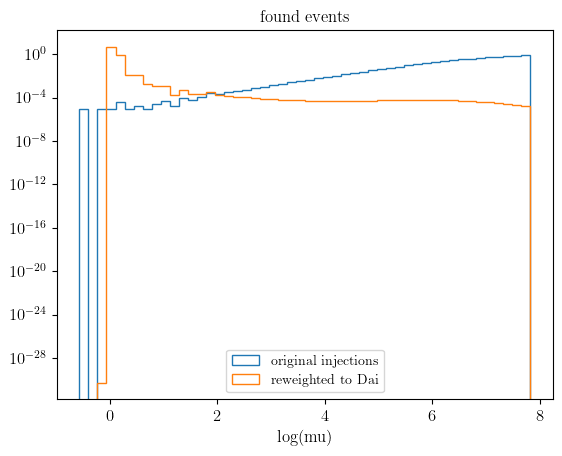

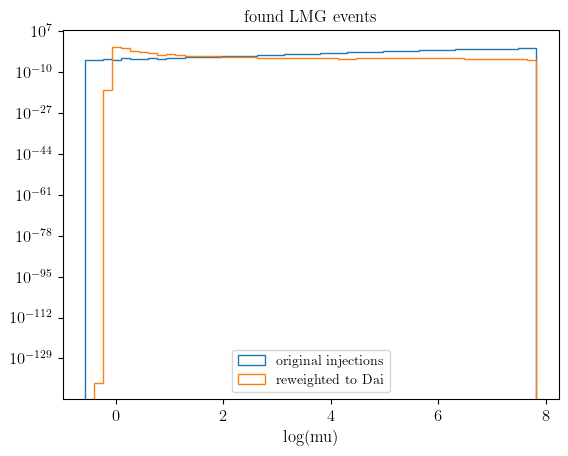

In [ ]:
hist_kwargs = dict(bins=50,density=True,histtype='step')
plt.hist(np.log(identified_evs_lensed['magnification']),**hist_kwargs,label='original injections')
plt.hist(np.log(identified_evs_lensed['magnification']),weights=identified_weights,**hist_kwargs,label='reweighted to Dai')
plt.legend()
plt.xlabel("log(mu)")
plt.yscale('log')
plt.title("found events")
plt.show()

plt.hist(np.log(obs_found_evs_lensed['magnification']),**hist_kwargs,label='original injections')
plt.hist(np.log(obs_found_evs_lensed['magnification']),weights=found_weights,**hist_kwargs,label='reweighted to Dai')
plt.legend()
plt.xlabel("log(mu)")
plt.yscale('log')
plt.title("found LMG events")
plt.show()


In [30]:
np.trapz(mu_interp((ln_mu_space,5,100)),ln_mu_space)

0.9999998681727987

In [20]:
np.trapz(np.ones_like(ln_mu_space)/(log_max_mag - log_min_mag),ln_mu_space)

1.0

In [ ]:
np.log(min_mag)##== ln_mu_space[0]

-2.3025850929940455